In [5]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); 
Pkg.instantiate()

using ForwardDiff
using LinearAlgebra
using Statistics
using Plots
plotlyjs()
using Printf
using Random
using DifferentialEquations

  Activating project at `~/Desktop/Work/Courses/OCRL-Walker-Project/juliaImplementation/juliaImplementation`


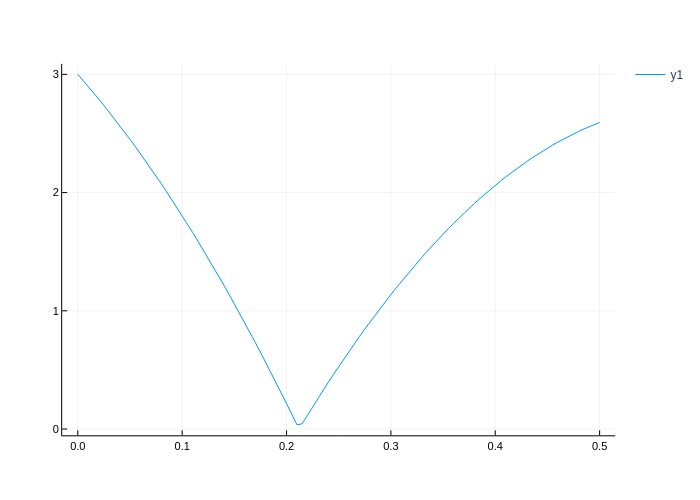

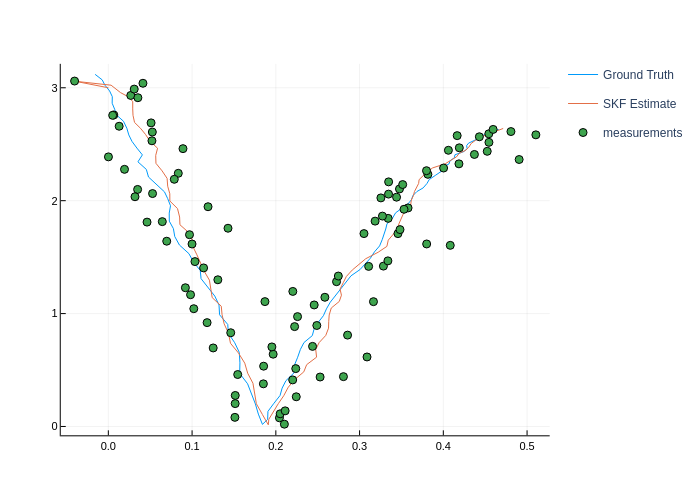

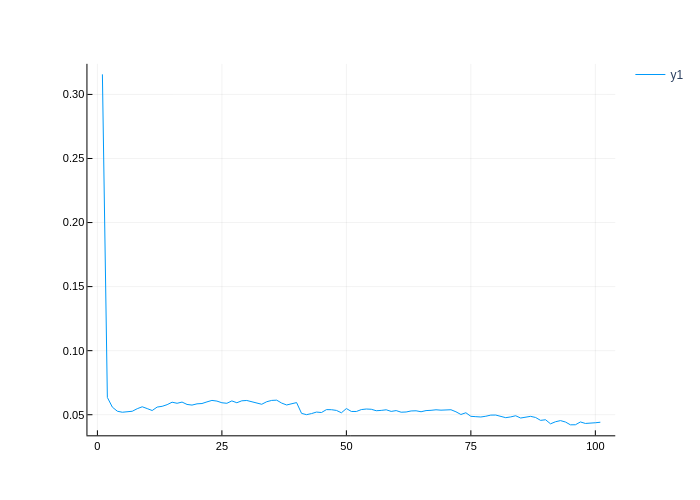

In [6]:
const FD = ForwardDiff;

PLOTS_DEFAULTS = Dict(:dpi => 600);

include("GeneralizedFunctionality/est_parameters.jl");
include("GeneralizedFunctionality/hybrid_system_simulation_tools.jl")
include("GeneralizedFunctionality/SKF_general.jl")
include("GeneralizedFunctionality/batch_estimation.jl")
include("GeneralizedFunctionality/generalized_saltation_calculations.jl")
include("DynamicSystems/bouncing_ball.jl") # Defines hybrid system functions

#Falling ball system definition
dynamics = [balldynamics,balldynamics]
resets = [[idreset,groundreset],[airreset,idreset]]
guards = [[idguard,groundguard],[airguard,idguard]]

In [ ]:
#Definining initial states
mode0 = 1
Σ = Diagonal([0.05,0.05,0.001,0.001])*1
xmean = [0.0,3.0,0.5,-5.0]

#Simulation times
t = 1.0 #10
dt = .01 #.1

#noise and measurement parameters
W = Diagonal([1.0,1.0,1.0,1.0])*0.1
V = Diagonal([1.0,1.0])*.001
C = [I zeros(2,2)]

#structure of all this
param = ESTParameters(C,V,W,dt,dynamics,resets,guards)

In [ ]:
#Nominal Trajectory
nom_states, _, _, nom_modes,nom_impact_states,_ = sim_system(xmean,mode0,dynamics,resets,guards,W*.000000000000001,V,C,t,dt)

plot([state[1] for state in nom_states],[state[2] for state in nom_states])
display(plot!())

In [ ]:
#Noisy Trajectory & Single Kalman Filter Solve
Random.seed!(1) # get a trial consistently
xstart = xmean + sqrt(Σ)*randn(size(xmean))

states, measurements = sim_system(xstart,mode0,dynamics,resets,guards,W,V,C,t,dt)
est_states, _ = skf(param,xmean,Σ,mode0,measurements)
plot([state[1] for state in states],[state[2] for state in states],label="Ground Truth")
plot!([state[1] for state in est_states],[state[2] for state in est_states],label="SKF Estimate")
scatter!([meas[1] for meas in measurements],[meas[2] for meas in measurements],label="measurements")
display(plot!())

# Multiple Trials for SKF:
iters = 10
random_seed = 3

avg_err, avg_step_err, avg_error, avgTime, step_err_kf = runMultipleKF(dynamics,resets,guards,W,V,C,xmean,Σ,mode0,t,dt;num_iters=iters,randseed=random_seed);

display(plot(avg_step_err))